In [1]:
import pandas as pd
import re
import itertools
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import igraph as ig
from IPython.display import HTML
import multiprocessing
import pickle as pkl
import random
from collections import Counter
import os
import subprocess
from scipy.stats import mannwhitneyu
import ete3
from copy import deepcopy
from math import ceil
import openpyxl

%cd /nobackup1b/users/payette/PVCtree

ncbi = ete3.NCBITaxa()

%run assess_connections-functions.ipynb

/nobackup1c/users/payette/PVCtree


In [2]:
PVCtree_sampled_genomes = pd.read_csv('PVC_group_Rprots.csv', index_col=1)

In [3]:
lineages = pd.DataFrame()
for taxid in PVCtree_sampled_genomes['TaxID'].unique():
    if pd.isna(taxid):
        continue
    lineages = lineages.append({tax_rank: tmp_taxid 
                                 for tmp_taxid, tax_rank in ncbi.get_rank(ncbi.get_lineage(taxid)).items()},
                                ignore_index=True)
lineages = lineages.reindex(columns=['class', 'family',  'genus', 'phylum',
                                     'order', 'species', 'superkingdom']).copy()
lineages = lineages.query('superkingdom == 2').copy()

In [4]:
#one liner to make all Proteobacteria (1224) classes into phyla
#lineages.loc[lineages['phylum']==1224, 'phylum'] = lineages.loc[lineages['phylum']==1224, 'class']

In [5]:
sampled_phyla = [phylum for phylum in lineages.phylum.unique().astype(int) if phylum > 0]

In [6]:
working_groups  = pd.read_parquet('PVC_working_eggNOG_groups.parquet')
working_trees   = pd.read_parquet( 'PVC_working_eggNOG_trees.parquet')
eggNOG_taxonomy = pd.read_parquet(      'PVC_eggNOG_taxonomy.parquet')

In [7]:
# Load previously run data from find_transfers code.
with open('PVC_new_phyla_results.pkl', 'rb') as _: 
     phylum_connections = pkl.load(_)

In [8]:
regular_connections     = []
significant_connections = []

for group_id, group_clusters in phylum_connections:
    if not group_clusters:
        continue
    
    for cluster_num, cluster_data in group_clusters.items():

        for ref_phylum, phyla_dists in cluster_data.items():
            
#             if not phyla_dists['df'].shape[0]:
#                 continue

            #
            # what is the closest <phylum> to <reference phylum>
            closest_phylum = phyla_dists['df'].iloc[0, 0]
            #
            # if the closest <phylum> is not among the ones we are interested at, 
            #   ignore this one and go to the next <reference phylum>
            if not closest_phylum in sampled_phyla:
                continue

            #
            # if distance between <reference phylum> and its closest phylum is significant...
            if phyla_dists['significant']:
                
                #
                # add it to the list of potential HGTs
                significant_connections.append( 
                    (ref_phylum,
                     phyla_dists['df'].iloc[0, 0], # closest phylum's name
                     phyla_dists['df'].iloc[0, 1], # avg. distance between phyla
                     '%s#%i' % (group_id, cluster_num)) 
                )

                #
                # and the second closest phylum onwards to regular relationships
                #   a.k.a. not HGTs...
                for index, tmp_series in phyla_dists['df'].iloc[1:, :].iterrows():
                    if tmp_series.phylum in sampled_phyla:
                        regular_connections.append( (ref_phylum,
                                                     tmp_series.phylum,
                                                     tmp_series['median'], 
                                                     '%s#%i' % (group_id, cluster_num)) )

            #
            # if the distance is not significant, just add everyting to regular
            #   relationships...
            else:
                for index, tmp_series in phyla_dists['df'].iterrows():
                    if tmp_series.phylum in sampled_phyla:
                        regular_connections.append( (ref_phylum,
                                                     tmp_series.phylum,
                                                     tmp_series['median'], 
                                                     '%s#%i' % (group_id, cluster_num)) )

significant_df = pd.DataFrame(data   =significant_connections, 
                              columns=['source', 'target', 'distance', 'group'])
regular_df     = pd.DataFrame(data   =regular_connections,     
                              columns=['source', 'target', 'distance', 'group'])

significant_df.dropna(how='any', inplace=True)
regular_df.dropna(    how='any', inplace=True)

In [9]:
significant_df.source.unique()

array([ 74201, 203682, 204428])

In [10]:
significant_df.target.unique()

array([203682,  74201, 204428])

In [11]:
closest_relation_freq = pd.DataFrame(columns=sampled_phyla)

for phylum in sampled_phyla:
    tmp = significant_df.query('source==@phylum').target.value_counts()
    tmp.name = phylum
    closest_relation_freq = closest_relation_freq.append(tmp)

phylum_names                    = {phylum:ncbi.translate_to_names([int(phylum)])[0] 
                                   for phylum in sampled_phyla}

#closest_relation_freq.drop(columns=[1798710], index=[1798710], inplace=True) #Melainabacteria 
closest_relation_freq.rename(columns=phylum_names, index=phylum_names, inplace=True)
closest_relation_freq = closest_relation_freq.stack().reset_index()

closest_relation_freq.rename(columns={'level_0':'reference', 
                                      'level_1':'target', 
                                      0        :'count'}, 
                             inplace=True)

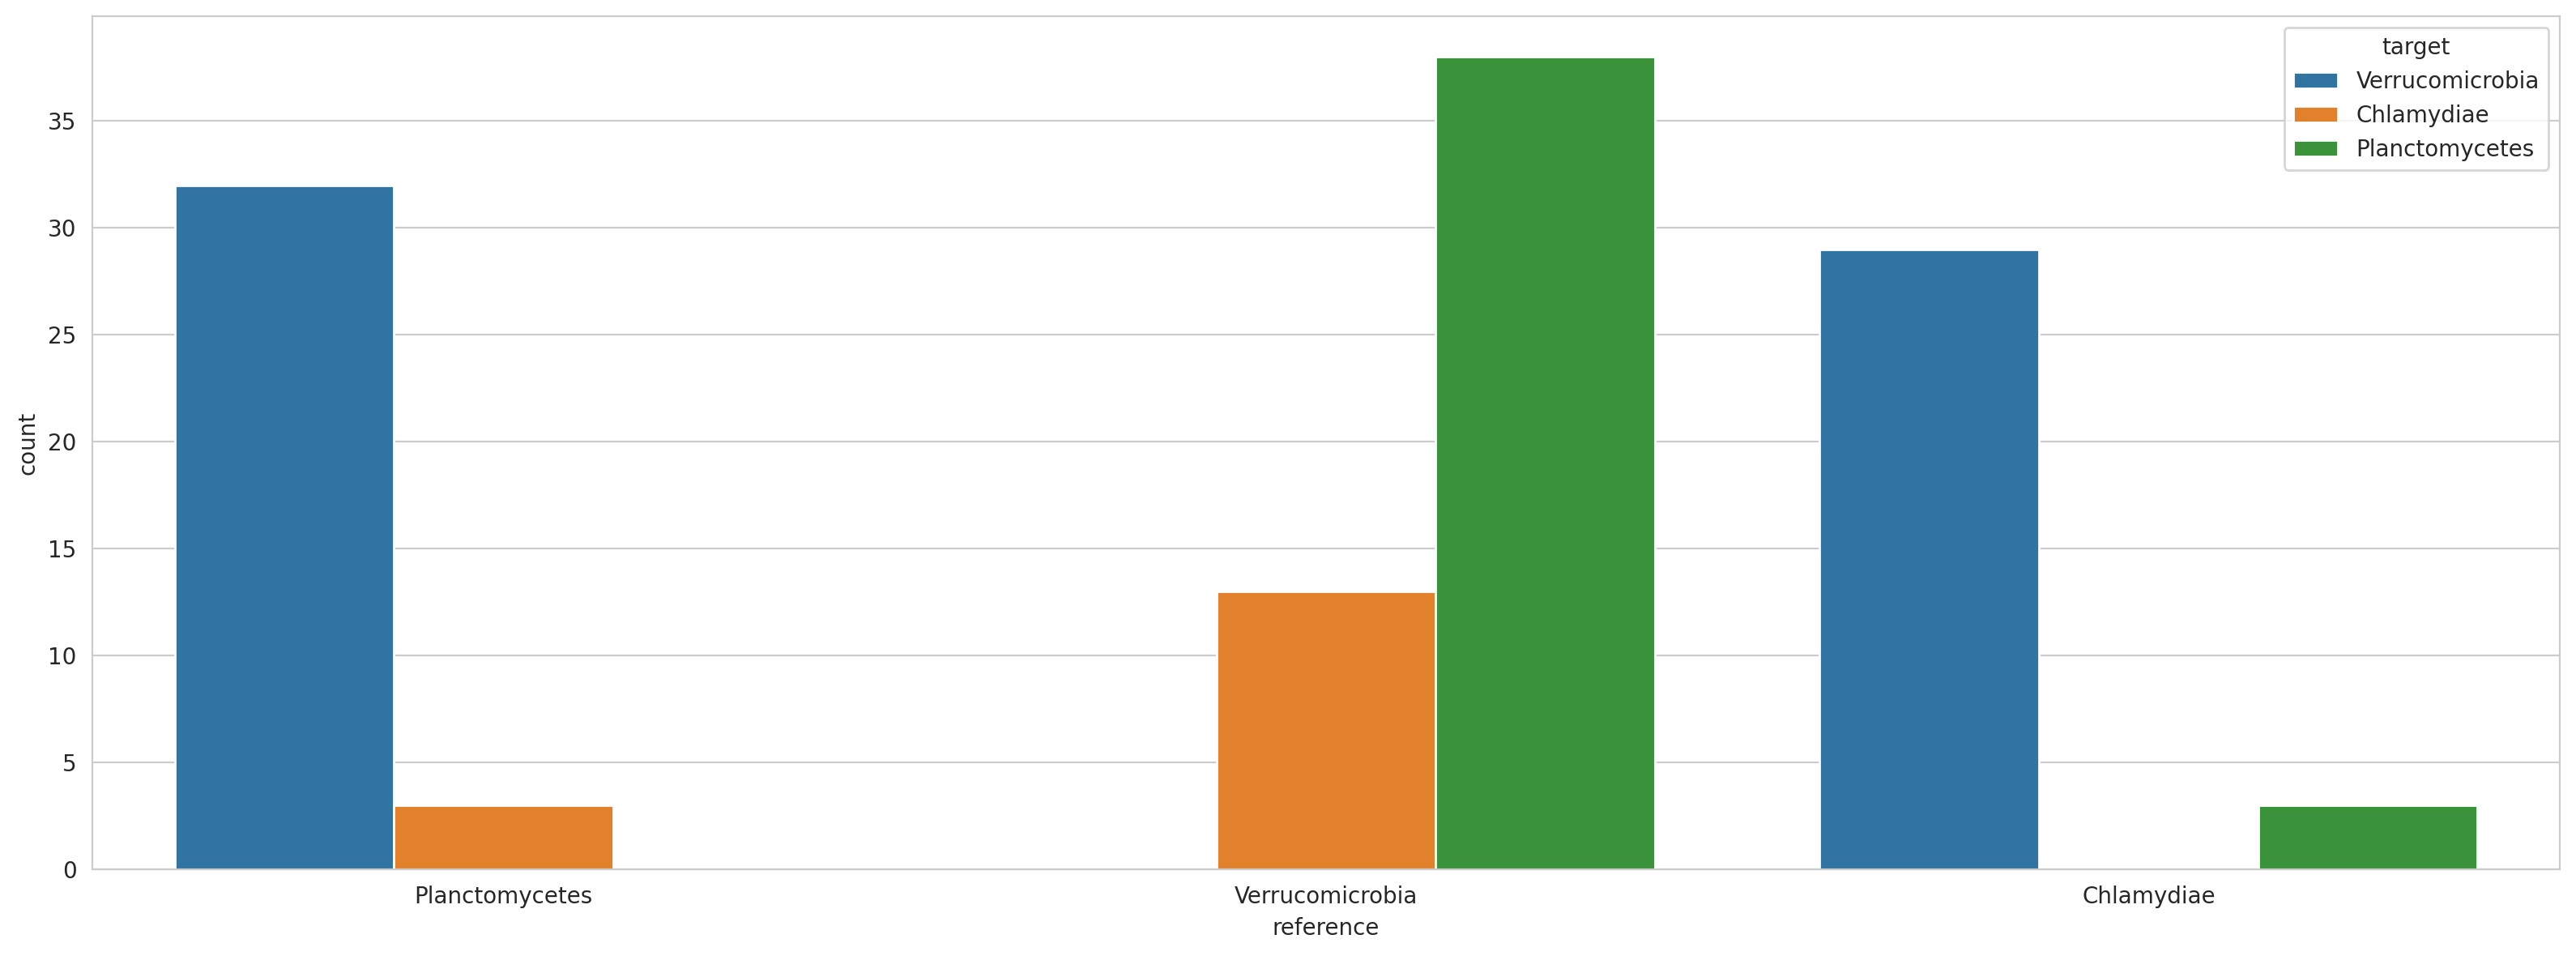

In [12]:
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(dpi=200, figsize=(16, 6))
    sns.barplot(x='reference', y='count', hue='target', data=closest_relation_freq, ax=ax)
    fig.tight_layout();

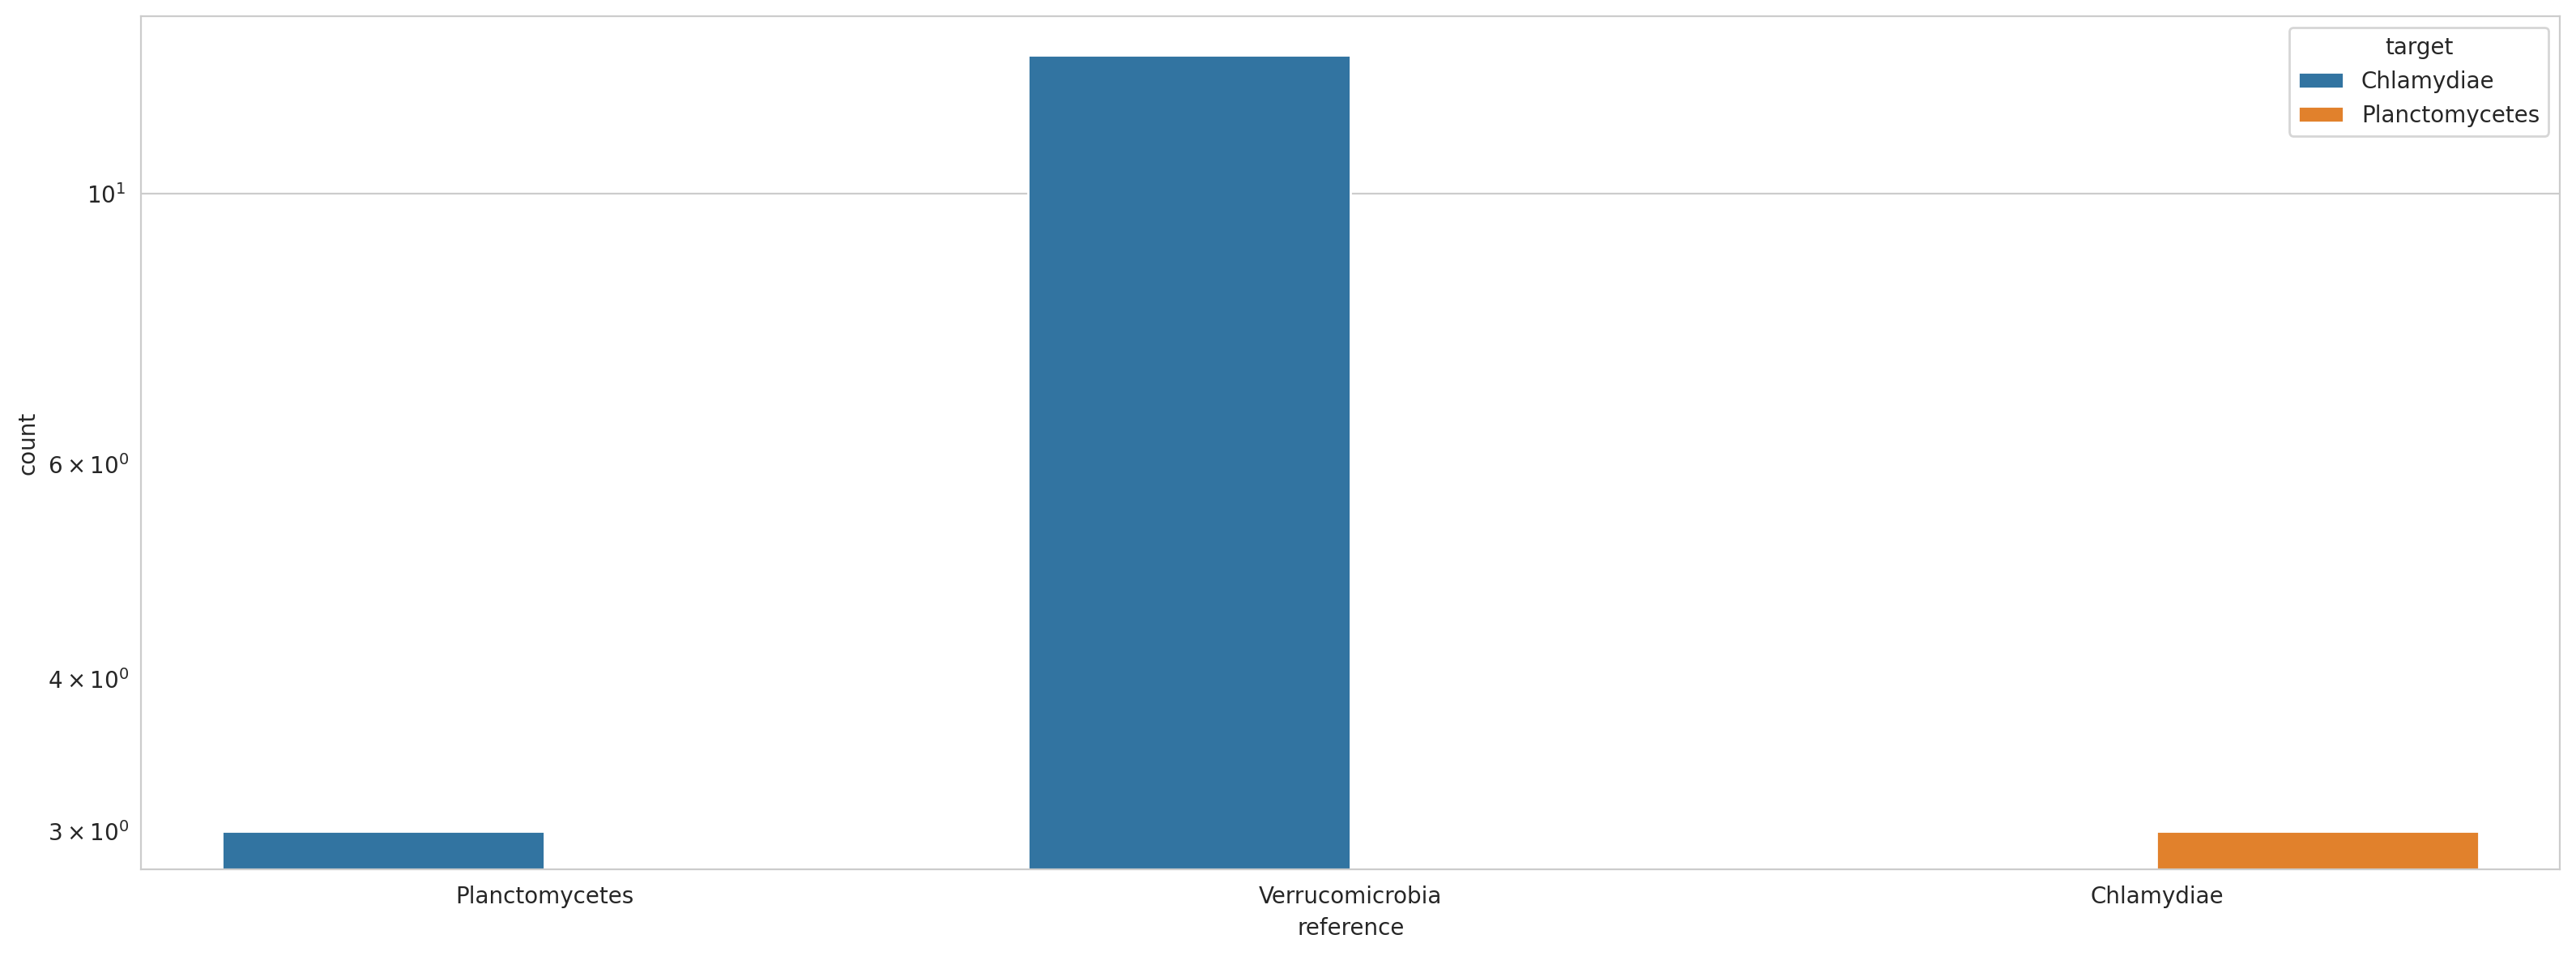

In [13]:
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(dpi=200, figsize=(16, 6))
    sns.barplot(x='reference', y='count', hue='target', data=closest_relation_freq.query('count<25'), ax=ax)
    ax.set(yscale="log")
    fig.tight_layout();

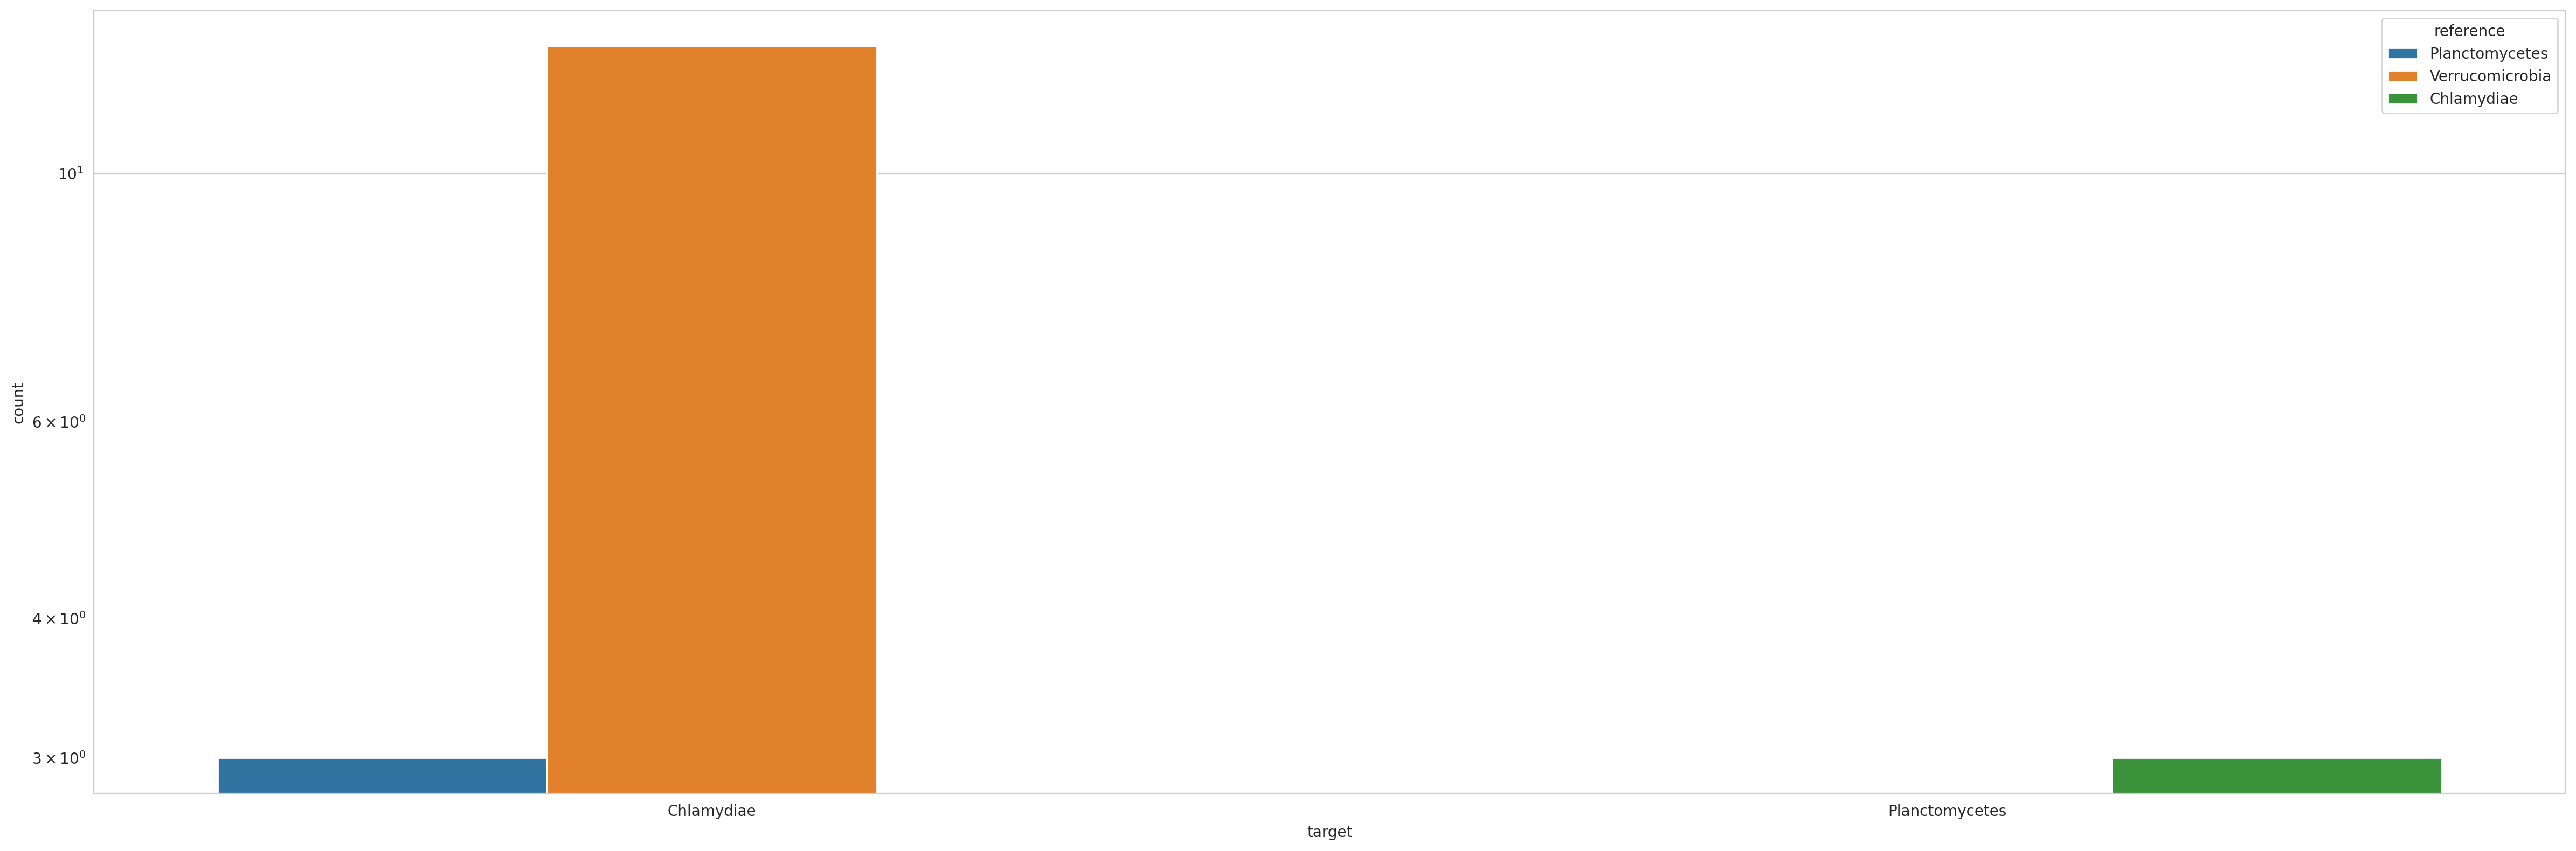

In [14]:
with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(dpi=200, figsize=(24, 8))
    sns.barplot(x='target', y='count', hue='reference', data=closest_relation_freq.query('count<25'), ax=ax)
    ax.set(yscale="log")
    fig.tight_layout();

In [15]:
print(closest_relation_freq)

         reference           target  count
0   Planctomycetes  Verrucomicrobia   32.0
1   Planctomycetes       Chlamydiae    3.0
2  Verrucomicrobia   Planctomycetes   38.0
3  Verrucomicrobia       Chlamydiae   13.0
4       Chlamydiae   Planctomycetes    3.0
5       Chlamydiae  Verrucomicrobia   29.0


In [16]:
closest_relation_freq.query('count>400')

,reference,target,count


In [20]:
closest_relation_freq

,reference,target,count
0,Planctomycetes,Verrucomicrobia,32.0
1,Planctomycetes,Chlamydiae,3.0
2,Verrucomicrobia,Planctomycetes,38.0
3,Verrucomicrobia,Chlamydiae,13.0
4,Chlamydiae,Planctomycetes,3.0
5,Chlamydiae,Verrucomicrobia,29.0


In [21]:
#Export to excel -- turn off for additional runs beyond first
closest_relation_freq.sort_values(by='count').to_excel("PVC_closest_relation_freq.xlsx")

In [22]:
### Begin analysis

In [23]:
#
# fastTree
#

def assess_transfers_between_phyla(related_phyla):
# related_phyla = (1090, 1117)

    candidates    = set(significant_df.query('source=="%i" and target=="%i"' % related_phyla).group.values).union(
                        significant_df.query('target=="%i" and source=="%i"' % related_phyla).group.values
                    )
    descriptions  = {f'from {related_phyla[0]} to {related_phyla[1]}': set(),
                     f'from {related_phyla[1]} to {related_phyla[0]}': set(),
                      'sisters':                                       set(),
                      'no clear relationship between phyla':           set()}

    for candidate in candidates:

        group_id, cluster_num = candidate.split('#')

        with cd('candidates/'):
            #
            # test if there is rooted version of the tree (mad output) 
            if not os.path.isfile('trees/%s-cluster%s.fastTree.rooted' % (group_id, cluster_num)):
                  reconstruct_candidate_fastTree(candidate)

            #
            # we need the original tree cause mad removes support values, so we just transfer root positions
            try:
                tmp_tree   = match_rooting(ete3.Tree('trees/%s-cluster%s.fastTree.rooted' % (group_id, cluster_num)),
                                           ete3.Tree('trees/%s-cluster%s.fastTree'        % (group_id, cluster_num)))
            except ete3.parser.newick.NewickError:
                continue

        #
        # extract taxIDs to subsample taxonomy tables
        taxids = {}
        for leaf in tmp_tree.get_leaf_names():
            #
            # leaf names are composed by <taxid>.<locus_tag>
            #   ps: locus_tag may also have "." within it
            tmp_taxid = int(leaf.split('.')[0])

            if tmp_taxid not in taxids:
                taxids[tmp_taxid] = []
            taxids[tmp_taxid].append(leaf)

        #
        # select taxIDs from each assessed phylum...
        phylum1_taxonomy = eggNOG_taxonomy.loc[taxids].query('phylum==@related_phyla[0]')
        phylum2_taxonomy = eggNOG_taxonomy.loc[taxids].query('phylum==@related_phyla[1]')

        #
        # ... and their respect leaves
        phylum1_leaves = set()
        for taxid in phylum1_taxonomy.index:
            phylum1_leaves.update(taxids[taxid])

        phylum2_leaves = set()
        for taxid in phylum2_taxonomy.index:
            phylum2_leaves.update(taxids[taxid])
        
        all_leaves = phylum1_leaves.union(phylum2_leaves)

        #
        # as tree traversing through ete3 isn't very efficient, and doesn't scalate very well,
        #   we create an iGraph dag for more effient traversing
        dag  = tree_to_dag(tmp_tree)          # we need a directed version...
        udag = dag.as_undirected(mode='each') # ... and an undirected one for different processes

        #
        # placeholders where we will add monophyletic clades for each phylum
        phylum1_clades = set() 
        phylum2_clades = set()

        ignored_nodes  = [] # descendants of monophyletic nodes should be ignored once their
                            #   ancestors have been stored.

        #
        # traverse through internal nodes
        for node in dag.vs:
            if node.index in ignored_nodes:
                continue

            node_leaves = get_leaf_names(node)

            if all_leaves.isdisjoint(node_leaves):
                ignored_nodes.extend(get_descendant_indices(node, leaves=True))

            #
            # if there aren't leaves from other phyla within this node it is monophyletic
            if phylum1_leaves.intersection(node_leaves) and phylum1_leaves.issuperset(node_leaves):
                phylum1_clades.add(node.index)
                ignored_nodes.extend(get_descendant_indices(node, leaves=True))

            elif phylum2_leaves.intersection(node_leaves) and phylum2_leaves.issuperset(node_leaves):
                phylum2_clades.add(node.index)
                ignored_nodes.extend(get_descendant_indices(node, leaves=True))

        #
        # now we add some flexibility to the monophyly of nodes for three reasons:
        #   1) donor nodes within gene trees will never be monophyletic since the recipient
        #      must be nested within it.
        #   2) if there are other transfers from the donor and/or recipient phyla to a 3rd one
        #      we still want to capture it.
        #   3) good ol' phylogenetic uncertainty
        phylum1_clades = merge_polyphyletic_clades(phylum1_clades, udag)
        phylum2_clades = merge_polyphyletic_clades(phylum2_clades, udag)

        #
        # flag if we can identify relations between phyla:
        #   1 nested within 2
        #   2 nested within 1
        #   1 and 2 are sisters
        #
        # if no relation is identified, leave as false
        phyla_relationship_flag = 0

        for clade1, clade2 in itertools.product(phylum1_clades, phylum2_clades):

            #
            # capture ancestors of clade1 by querying nodes between itself and the root node
            clade1_ancestors = udag.vs[clade1].get_shortest_paths(udag.vs[0])[0][1:]
            #
            # if clade2 within clade1 ancestors it means that clade1 is nested within clade2
            #   evidence of transfer from clade2 -> clade1
            if clade2 in clade1_ancestors:
                recipient_taxon         = fine_tune_recipient(dag.vs[clade1], 
                                                              related_phyla[0])
                donor_taxon             = fine_tune_recipient(dag.vs[clade2], 
                                                              related_phyla[1])
                phyla_relationship_flag = 1
                
                if (recipient_taxon, donor_taxon) != related_phyla:
                    descriptions[f'from {related_phyla[1]} to {related_phyla[0]}'].add('%s from %i to %i' % \
                                                                                       (candidate, donor_taxon, 
                                                                                        recipient_taxon))
                else:
                    descriptions[f'from {related_phyla[1]} to {related_phyla[0]}'].add(candidate)

                continue

            #
            # if clade1 within clade2 ancestors it means that clade2 is nested within clade1
            #   evidence of transfer from clade1 -> clade2
            clade2_ancestors = udag.vs[clade2].get_shortest_paths(udag.vs[0])[0][1:]
            if clade1 in clade2_ancestors:
                recipient_taxon         = fine_tune_recipient(dag.vs[clade2], 
                                                              related_phyla[1])
                donor_taxon             = fine_tune_recipient(dag.vs[clade1], 
                                                              related_phyla[0])
                phyla_relationship_flag = 1

                if (donor_taxon, recipient_taxon) !=  related_phyla:
                    descriptions[f'from {related_phyla[0]} to {related_phyla[1]}'].add('%s from %i to %i' % \
                                                                                       (candidate, donor_taxon, 
                                                                                        recipient_taxon))
                else:
                    descriptions[f'from {related_phyla[0]} to {related_phyla[1]}'].add(candidate)
                continue

            #
            # if clade1 and clade2 are have the same parent noe it means they are sisters
            #   evidence of hgt, but information about directionality
            if clade1_ancestors[0] == clade2_ancestors[0]:
                descriptions['sisters'].add(candidate)
                phyla_relationship_flag = 1
                continue

    #     with cd('candidates/'):
    #         with open('%s-cluster%s.figTree' % (group_id, cluster_num), 'w') as out:
    #             out.write(visualize_reconstruct_candidate(tmp_tree))

        #
        # if the flag still is False, we couldn't identify an relationship between phyla
        if not phyla_relationship_flag:
            descriptions['no clear relationship between phyla'].add(candidate)

    return(descriptions)

In [24]:
def assess_transfers_between_phyla2(related_phyla):
# related_phyla = (1090, 1117)

    candidates    = set(significant_df.query('source=="%i" and target=="%i"' % related_phyla).group.values).union(
                        significant_df.query('target=="%i" and source=="%i"' % related_phyla).group.values
                    )
    descriptions  = {f'from {related_phyla[0]} to {related_phyla[1]}': set(),
                     f'from {related_phyla[1]} to {related_phyla[0]}': set(),
                      'sisters':                                       set(),
                      'no clear relationship between phyla':           set()}

    for candidate in candidates:

        group_id, cluster_num = candidate.split('#')

        with cd('candidates/'):
            #
            # test if there is rooted version of the tree (mad output) 
            if not os.path.isfile('trees/%s-cluster%s.fastFigTree' % (group_id, cluster_num)):
                   visualize_reconstruct_candidate_fastTree2(candidate)

            #
            # we need the original tree cause mad removes support values, so we just transfer root positions
            try:
                tmp_tree   = match_rooting(ete3.Tree('trees/%s-cluster%s.treefile.rooted' % (group_id, cluster_num)),
                                           ete3.Tree('trees/%s-cluster%s.treefile'        % (group_id, cluster_num)))
            except ete3.parser.newick.NewickError:
                continue

        #
        # extract taxIDs to subsample taxonomy tables
        taxids = {}
        for leaf in tmp_tree.get_leaf_names():
            #
            # leaf names are composed by <taxid>.<locus_tag>
            #   ps: locus_tag may also have "." within it
            tmp_taxid = int(leaf.split('.')[0])

            if tmp_taxid not in taxids:
                taxids[tmp_taxid] = []
            taxids[tmp_taxid].append(leaf)

        #
        # select taxIDs from each assessed phylum...
        phylum1_taxonomy = eggNOG_taxonomy.loc[taxids].query('phylum==@related_phyla[0]')
        phylum2_taxonomy = eggNOG_taxonomy.loc[taxids].query('phylum==@related_phyla[1]')

        #
        # ... and their respect leaves
        phylum1_leaves = set()
        for taxid in phylum1_taxonomy.index:
            phylum1_leaves.update(taxids[taxid])

        phylum2_leaves = set()
        for taxid in phylum2_taxonomy.index:
            phylum2_leaves.update(taxids[taxid])
        
        all_leaves = phylum1_leaves.union(phylum2_leaves)

        #
        # as tree traversing through ete3 isn't very efficient, and doesn't scalate very well,
        #   we create an iGraph dag for more effient traversing
        dag  = tree_to_dag(tmp_tree)          # we need a directed version...
        udag = dag.as_undirected(mode='each') # ... and an undirected one for different processes

        #
        # placeholders where we will add monophyletic clades for each phylum
        phylum1_clades = set() 
        phylum2_clades = set()

        ignored_nodes  = [] # descendants of monophyletic nodes should be ignored once their
                            #   ancestors have been stored.

        #
        # traverse through internal nodes
        for node in dag.vs:
            if node.index in ignored_nodes:
                continue

            node_leaves = get_leaf_names(node)

            if all_leaves.isdisjoint(node_leaves):
                ignored_nodes.extend(get_descendant_indices(node, leaves=True))

            #
            # if there aren't leaves from other phyla within this node it is monophyletic
            if phylum1_leaves.intersection(node_leaves) and phylum1_leaves.issuperset(node_leaves):
                phylum1_clades.add(node.index)
                ignored_nodes.extend(get_descendant_indices(node, leaves=True))

            elif phylum2_leaves.intersection(node_leaves) and phylum2_leaves.issuperset(node_leaves):
                phylum2_clades.add(node.index)
                ignored_nodes.extend(get_descendant_indices(node, leaves=True))

        #
        # now we add some flexibility to the monophyly of nodes for three reasons:
        #   1) donor nodes within gene trees will never be monophyletic since the recipient
        #      must be nested within it.
        #   2) if there are other transfers from the donor and/or recipient phyla to a 3rd one
        #      we still want to capture it.
        #   3) good ol' phylogenetic uncertainty
        phylum1_clades = merge_polyphyletic_clades(phylum1_clades, udag)
        phylum2_clades = merge_polyphyletic_clades(phylum2_clades, udag)

        #
        # flag if we can identify relations between phyla:
        #   1 nested within 2
        #   2 nested within 1
        #   1 and 2 are sisters
        #
        # if no relation is identified, leave as false
        phyla_relationship_flag = 0

        for clade1, clade2 in itertools.product(phylum1_clades, phylum2_clades):

            #
            # capture ancestors of clade1 by querying nodes between itself and the root node
            clade1_ancestors = udag.vs[clade1].get_shortest_paths(udag.vs[0])[0][1:]
            #
            # if clade2 within clade1 ancestors it means that clade1 is nested within clade2
            #   evidence of transfer from clade2 -> clade1
            if clade2 in clade1_ancestors:
                recipient_taxon         = fine_tune_recipient(dag.vs[clade1], 
                                                              related_phyla[0])
                donor_taxon             = fine_tune_recipient(dag.vs[clade2], 
                                                              related_phyla[1])
                phyla_relationship_flag = 1
                
                if (recipient_taxon, donor_taxon) != related_phyla:
                    descriptions[f'from {related_phyla[1]} to {related_phyla[0]}'].add('%s from %i to %i' % \
                                                                                       (candidate, donor_taxon, 
                                                                                        recipient_taxon))
                else:
                    descriptions[f'from {related_phyla[1]} to {related_phyla[0]}'].add(candidate)

                continue

            #
            # if clade1 within clade2 ancestors it means that clade2 is nested within clade1
            #   evidence of transfer from clade1 -> clade2
            clade2_ancestors = udag.vs[clade2].get_shortest_paths(udag.vs[0])[0][1:]
            if clade1 in clade2_ancestors:
                recipient_taxon         = fine_tune_recipient(dag.vs[clade2], 
                                                              related_phyla[1])
                donor_taxon             = fine_tune_recipient(dag.vs[clade1], 
                                                              related_phyla[0])
                phyla_relationship_flag = 1

                if (donor_taxon, recipient_taxon) !=  related_phyla:
                    descriptions[f'from {related_phyla[0]} to {related_phyla[1]}'].add('%s from %i to %i' % \
                                                                                       (candidate, donor_taxon, 
                                                                                        recipient_taxon))
                else:
                    descriptions[f'from {related_phyla[0]} to {related_phyla[1]}'].add(candidate)
                continue

            #
            # if clade1 and clade2 are have the same parent noe it means they are sisters
            #   evidence of hgt, but information about directionality
            if clade1_ancestors[0] == clade2_ancestors[0]:
                descriptions['sisters'].add(candidate)
                phyla_relationship_flag = 1
                continue

    #     with cd('candidates/'):
    #         with open('%s-cluster%s.figTree' % (group_id, cluster_num), 'w') as out:
    #             out.write(visualize_reconstruct_candidate(tmp_tree))

        #
        # if the flag still is False, we couldn't identify an relationship between phyla
        if not phyla_relationship_flag:
            descriptions['no clear relationship between phyla'].add(candidate)

    return(descriptions)

In [25]:
def assess_transfers_between_phyla3(related_phyla):
# related_phyla = (1090, 1117)

    candidates    = set(significant_df.query('source=="%i" and target=="%i"' % related_phyla).group.values).union(
                        significant_df.query('target=="%i" and source=="%i"' % related_phyla).group.values
                    )
    descriptions  = {f'from {related_phyla[0]} to {related_phyla[1]}': set(),
                     f'from {related_phyla[1]} to {related_phyla[0]}': set(),
                      'sisters':                                       set(),
                      'no clear relationship between phyla':           set()}

    for candidate in candidates:

        group_id, cluster_num = candidate.split('#')

        with cd('candidates/'):
            #
            # test if there is rooted version of the tree (mad output) 
            if not os.path.isfile('trees/%s-cluster%s.treefile' % (group_id, cluster_num)):
                   reconstruct_candidate_quick(candidate)

            #
            # we need the original tree cause mad removes support values, so we just transfer root positions
            try:
                tmp_tree   = match_rooting(ete3.Tree('trees/%s-cluster%s.treefile.rooted' % (group_id, cluster_num)),
                                           ete3.Tree('trees/%s-cluster%s.treefile'        % (group_id, cluster_num)))
            except ete3.parser.newick.NewickError:
                continue

        #
        # extract taxIDs to subsample taxonomy tables
        taxids = {}
        for leaf in tmp_tree.get_leaf_names():
            #
            # leaf names are composed by <taxid>.<locus_tag>
            #   ps: locus_tag may also have "." within it
            tmp_taxid = int(leaf.split('.')[0])

            if tmp_taxid not in taxids:
                taxids[tmp_taxid] = []
            taxids[tmp_taxid].append(leaf)

        #
        # select taxIDs from each assessed phylum...
        phylum1_taxonomy = eggNOG_taxonomy.loc[taxids].query('phylum==@related_phyla[0]')
        phylum2_taxonomy = eggNOG_taxonomy.loc[taxids].query('phylum==@related_phyla[1]')

        #
        # ... and their respect leaves
        phylum1_leaves = set()
        for taxid in phylum1_taxonomy.index:
            phylum1_leaves.update(taxids[taxid])

        phylum2_leaves = set()
        for taxid in phylum2_taxonomy.index:
            phylum2_leaves.update(taxids[taxid])
        
        all_leaves = phylum1_leaves.union(phylum2_leaves)

        #
        # as tree traversing through ete3 isn't very efficient, and doesn't scalate very well,
        #   we create an iGraph dag for more effient traversing
        dag  = tree_to_dag(tmp_tree)          # we need a directed version...
        udag = dag.as_undirected(mode='each') # ... and an undirected one for different processes

        #
        # placeholders where we will add monophyletic clades for each phylum
        phylum1_clades = set() 
        phylum2_clades = set()

        ignored_nodes  = [] # descendants of monophyletic nodes should be ignored once their
                            #   ancestors have been stored.

        #
        # traverse through internal nodes
        for node in dag.vs:
            if node.index in ignored_nodes:
                continue

            node_leaves = get_leaf_names(node)

            if all_leaves.isdisjoint(node_leaves):
                ignored_nodes.extend(get_descendant_indices(node, leaves=True))

            #
            # if there aren't leaves from other phyla within this node it is monophyletic
            if phylum1_leaves.intersection(node_leaves) and phylum1_leaves.issuperset(node_leaves):
                phylum1_clades.add(node.index)
                ignored_nodes.extend(get_descendant_indices(node, leaves=True))

            elif phylum2_leaves.intersection(node_leaves) and phylum2_leaves.issuperset(node_leaves):
                phylum2_clades.add(node.index)
                ignored_nodes.extend(get_descendant_indices(node, leaves=True))

        #
        # now we add some flexibility to the monophyly of nodes for three reasons:
        #   1) donor nodes within gene trees will never be monophyletic since the recipient
        #      must be nested within it.
        #   2) if there are other transfers from the donor and/or recipient phyla to a 3rd one
        #      we still want to capture it.
        #   3) good ol' phylogenetic uncertainty
        phylum1_clades = merge_polyphyletic_clades(phylum1_clades, udag)
        phylum2_clades = merge_polyphyletic_clades(phylum2_clades, udag)

        #
        # flag if we can identify relations between phyla:
        #   1 nested within 2
        #   2 nested within 1
        #   1 and 2 are sisters
        #
        # if no relation is identified, leave as false
        phyla_relationship_flag = 0

        for clade1, clade2 in itertools.product(phylum1_clades, phylum2_clades):

            #
            # capture ancestors of clade1 by querying nodes between itself and the root node
            clade1_ancestors = udag.vs[clade1].get_shortest_paths(udag.vs[0])[0][1:]
            #
            # if clade2 within clade1 ancestors it means that clade1 is nested within clade2
            #   evidence of transfer from clade2 -> clade1
            if clade2 in clade1_ancestors:
                recipient_taxon         = fine_tune_recipient(dag.vs[clade1], 
                                                              related_phyla[0])
                donor_taxon             = fine_tune_recipient(dag.vs[clade2], 
                                                              related_phyla[1])
                phyla_relationship_flag = 1
                
                if (recipient_taxon, donor_taxon) != related_phyla:
                    descriptions[f'from {related_phyla[1]} to {related_phyla[0]}'].add('%s from %i to %i' % \
                                                                                       (candidate, donor_taxon, 
                                                                                        recipient_taxon))
                else:
                    descriptions[f'from {related_phyla[1]} to {related_phyla[0]}'].add(candidate)

                continue

            #
            # if clade1 within clade2 ancestors it means that clade2 is nested within clade1
            #   evidence of transfer from clade1 -> clade2
            clade2_ancestors = udag.vs[clade2].get_shortest_paths(udag.vs[0])[0][1:]
            if clade1 in clade2_ancestors:
                recipient_taxon         = fine_tune_recipient(dag.vs[clade2], 
                                                              related_phyla[1])
                donor_taxon             = fine_tune_recipient(dag.vs[clade1], 
                                                              related_phyla[0])
                phyla_relationship_flag = 1

                if (donor_taxon, recipient_taxon) !=  related_phyla:
                    descriptions[f'from {related_phyla[0]} to {related_phyla[1]}'].add('%s from %i to %i' % \
                                                                                       (candidate, donor_taxon, 
                                                                                        recipient_taxon))
                else:
                    descriptions[f'from {related_phyla[0]} to {related_phyla[1]}'].add(candidate)
                continue

            #
            # if clade1 and clade2 are have the same parent noe it means they are sisters
            #   evidence of hgt, but information about directionality
            if clade1_ancestors[0] == clade2_ancestors[0]:
                descriptions['sisters'].add(candidate)
                phyla_relationship_flag = 1
                continue

    #     with cd('candidates/'):
    #         with open('%s-cluster%s.figTree' % (group_id, cluster_num), 'w') as out:
    #             out.write(visualize_reconstruct_candidate(tmp_tree))

        #
        # if the flag still is False, we couldn't identify an relationship between phyla
        if not phyla_relationship_flag:
            descriptions['no clear relationship between phyla'].add(candidate)

    return(descriptions)

In [26]:
#Example of pipeline -- reconstruct & visualize
#
#reconstruct_candidate_fastTree('COG0049#3')
#visualize_reconstruct_candidate_fastTree2('COG0049#3')
#
# # descriptions = assess_transfers_between_phyla((200795, 1117))

In [27]:
print(sampled_phyla)

[203682, 74201, 204428, 256845, 265317]


In [28]:
for each in itertools.combinations(sampled_phyla, 2):
    print(each)

(203682, 74201)
(203682, 204428)
(203682, 256845)
(203682, 265317)
(74201, 204428)
(74201, 256845)
(74201, 265317)
(204428, 256845)
(204428, 265317)
(256845, 265317)


In [29]:
print(sampled_phyla)

[203682, 74201, 204428, 256845, 265317]


In [30]:
sub_sampled_phyla = ((203682, 74201),
(203682, 204428),
(203682, 256845),
(203682, 265317),
(74201, 204428),
(74201, 256845),
(74201, 265317),
(204428, 256845),
(204428, 265317),
(256845, 265317))

In [31]:
!pwd

/nobackup1c/users/payette/PVCtree


In [32]:
for phylum_pair in sub_sampled_phyla:
    phylum_names                    = {phylum:ncbi.translate_to_names([int(phylum)])[0] 
                                   for phylum in phylum_pair}
    print(phylum_names)
    print(phylum_pair)

{203682: 'Planctomycetes', 74201: 'Verrucomicrobia'}
(203682, 74201)
{203682: 'Planctomycetes', 204428: 'Chlamydiae'}
(203682, 204428)
{203682: 'Planctomycetes', 256845: 'Lentisphaerae'}
(203682, 256845)
{203682: 'Planctomycetes', 265317: 'Candidatus Poribacteria'}
(203682, 265317)
{74201: 'Verrucomicrobia', 204428: 'Chlamydiae'}
(74201, 204428)
{74201: 'Verrucomicrobia', 256845: 'Lentisphaerae'}
(74201, 256845)
{74201: 'Verrucomicrobia', 265317: 'Candidatus Poribacteria'}
(74201, 265317)
{204428: 'Chlamydiae', 256845: 'Lentisphaerae'}
(204428, 256845)
{204428: 'Chlamydiae', 265317: 'Candidatus Poribacteria'}
(204428, 265317)
{256845: 'Lentisphaerae', 265317: 'Candidatus Poribacteria'}
(256845, 265317)


In [33]:
#Run assess_transfers for Fast Trees
descriptions = {}
for phylum_pair in sub_sampled_phyla:
    phylum_names                     = {phylum:ncbi.translate_to_names([int(phylum)])[0] 
                                   for phylum in phylum_pair}
    print(phylum_names)
    print(phylum_pair)
    descriptions[phylum_pair] = assess_transfers_between_phyla(phylum_pair) #assess transfers, then reconstruct

{203682: 'Planctomycetes', 74201: 'Verrucomicrobia'}
(203682, 74201)
{203682: 'Planctomycetes', 204428: 'Chlamydiae'}
(203682, 204428)
{203682: 'Planctomycetes', 256845: 'Lentisphaerae'}
(203682, 256845)
{203682: 'Planctomycetes', 265317: 'Candidatus Poribacteria'}
(203682, 265317)
{74201: 'Verrucomicrobia', 204428: 'Chlamydiae'}
(74201, 204428)
{74201: 'Verrucomicrobia', 256845: 'Lentisphaerae'}
(74201, 256845)
{74201: 'Verrucomicrobia', 265317: 'Candidatus Poribacteria'}
(74201, 265317)
{204428: 'Chlamydiae', 256845: 'Lentisphaerae'}
(204428, 256845)
{204428: 'Chlamydiae', 265317: 'Candidatus Poribacteria'}
(204428, 265317)
{256845: 'Lentisphaerae', 265317: 'Candidatus Poribacteria'}
(256845, 265317)


In [34]:
for pair, description in descriptions.items():
    print(pair)
    phylum_names                    = {phylum:ncbi.translate_to_names([int(phylum)])[0] 
                                   for phylum in pair}
    print(phylum_names)
    for key, value in description.items():
        print(key, len(value))
    print()

(203682, 74201)
{203682: 'Planctomycetes', 74201: 'Verrucomicrobia'}
from 203682 to 74201 14
from 74201 to 203682 16
sisters 16
no clear relationship between phyla 14

(203682, 204428)
{203682: 'Planctomycetes', 204428: 'Chlamydiae'}
from 203682 to 204428 0
from 204428 to 203682 0
sisters 3
no clear relationship between phyla 1

(203682, 256845)
{203682: 'Planctomycetes', 256845: 'Lentisphaerae'}
from 203682 to 256845 0
from 256845 to 203682 0
sisters 0
no clear relationship between phyla 0

(203682, 265317)
{203682: 'Planctomycetes', 265317: 'Candidatus Poribacteria'}
from 203682 to 265317 0
from 265317 to 203682 0
sisters 0
no clear relationship between phyla 0

(74201, 204428)
{74201: 'Verrucomicrobia', 204428: 'Chlamydiae'}
from 74201 to 204428 6
from 204428 to 74201 1
sisters 6
no clear relationship between phyla 13

(74201, 256845)
{74201: 'Verrucomicrobia', 256845: 'Lentisphaerae'}
from 74201 to 256845 0
from 256845 to 74201 0
sisters 0
no clear relationship between phyla 0

(74

In [35]:
# Old code to print descriptions and COGs from output of assess_transfers
#
for pair, description in descriptions.items():
    print(pair)
    phylum_names                    = {phylum:ncbi.translate_to_names([int(phylum)])[0] 
                                   for phylum in pair}
    print(phylum_names)
    for key, value in description.items():
        print(key, value)
    print()

(203682, 74201)
{203682: 'Planctomycetes', 74201: 'Verrucomicrobia'}
from 203682 to 74201 {'COG0345#3 from 203683 to 74201', 'COG3302#0 from 203683 to 74201', '2ZA2Y#0 from 203683 to 203494', 'COG0331#0', 'COG1199#1', 'COG3258#2 from 203683 to 74201', '331S2#0 from 203682 to 48461', 'COG0437#0 from 203683 to 74201', 'COG0345#3 from 203683 to 48461', 'COG0114#1', 'COG4842#2', 'COG1099#1', 'COG0548#2', 'COG0441#5'}
from 74201 to 203682 {'COG0211#1 from 74201 to 203683', 'COG0018#0 from 74201 to 547188', 'COG0449#2 from 74201 to 203683', 'COG0211#1 from 74201 to 1210884', 'COG2115#2 from 74201 to 547188', '2ZB6C#1 from 74201 to 203683', 'COG1523#2 from 74201 to 203683', 'COG0018#0 from 74201 to 203683', 'COG0574#1 from 74201 to 360055', '331S2#0 from 74201 to 126', 'COG2081#3 from 74201 to 203683', 'COG0287#0 from 74201 to 203683', 'COG0211#1 from 74201 to 126', 'COG0824#2 from 74201 to 203683', 'COG2115#2 from 74201 to 203683', 'COG0370#9'}
sisters {'COG4956#1', '2ZB6C#1', 'COG1146#0', '

In [37]:
#Ensure you're in the root directory of the distHGT project folder and not candidates
os.chdir('/nobackup1c/users/payette/PVCtree/')
!pwd

/nobackup1c/users/payette/PVCtree


In [38]:
#Visualize fast trees
descriptions2 = {}
for phylum_pair in sub_sampled_phyla:
    phylum_names                     = {phylum:ncbi.translate_to_names([int(phylum)])[0] 
                                   for phylum in phylum_pair}
    print(phylum_names)
    print(phylum_pair)
    descriptions2[phylum_pair] = assess_transfers_between_phyla2(phylum_pair) #assess transfers, then reconstruct

{203682: 'Planctomycetes', 74201: 'Verrucomicrobia'}
(203682, 74201)


/home/payette/.conda/envs/py37/lib/python3.7/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 1408813 was translated into 947309
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/home/payette/.conda/envs/py37/lib/python3.7/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 62928 was translated into 418699
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/home/payette/.conda/envs/py37/lib/python3.7/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 1288963 was translated into 1232681
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/home/payette/.conda/envs/py37/lib/python3.7/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 1353531 was translated into 1708715
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/home/payette/.conda/envs/py37/lib/python3.7/site-packag

/home/payette/.conda/envs/py37/lib/python3.7/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 1344012 was translated into 480813
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/home/payette/.conda/envs/py37/lib/python3.7/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 656024 was translated into 2714109
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/home/payette/.conda/envs/py37/lib/python3.7/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 595593 was translated into 656366
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/home/payette/.conda/envs/py37/lib/python3.7/site-packages/ete3/ncbi_taxonomy/ncbiquery.py:243: UserWarning: taxid 443255 was translated into 1901
  warnings.warn("taxid %s was translated into %s" %(taxid, merged_conversion[taxid]))
/home/payette/.conda/envs/py37/lib/python3.7/site-packages/e

{203682: 'Planctomycetes', 204428: 'Chlamydiae'}
(203682, 204428)
{203682: 'Planctomycetes', 256845: 'Lentisphaerae'}
(203682, 256845)
{203682: 'Planctomycetes', 265317: 'Candidatus Poribacteria'}
(203682, 265317)
{74201: 'Verrucomicrobia', 204428: 'Chlamydiae'}
(74201, 204428)
{74201: 'Verrucomicrobia', 256845: 'Lentisphaerae'}
(74201, 256845)
{74201: 'Verrucomicrobia', 265317: 'Candidatus Poribacteria'}
(74201, 265317)
{204428: 'Chlamydiae', 256845: 'Lentisphaerae'}
(204428, 256845)
{204428: 'Chlamydiae', 265317: 'Candidatus Poribacteria'}
(204428, 265317)
{256845: 'Lentisphaerae', 265317: 'Candidatus Poribacteria'}
(256845, 265317)


In [39]:
with open('fastTree_nested_PVC', 'wb') as out: #ran at 11:45 11-18-20
    pkl.dump(descriptions2, out)

In [ ]:
# Run IQtrees
descriptions3 = {}
for phylum_pair in sub_sampled_phyla:
    phylum_names                     = {phylum:ncbi.translate_to_names([int(phylum)])[0] 
                                   for phylum in phylum_pair}
    print(phylum_names)
    print(phylum_pair)
    descriptions3[phylum_pair] = assess_transfers_between_phyla3(phylum_pair) #assess transfers, then reconstruct

{203682: 'Planctomycetes', 74201: 'Verrucomicrobia'}
(203682, 74201)


In [41]:
descriptions3

{(203682,
  74201): {'from 203682 to 74201': {'2ZA2Y#0 from 203683 to 2735',
   '2ZA2Y#0 from 203683 to 74201',
   '331S2#0 from 203682 to 48461',
   'COG0114#1',
   'COG0272#2',
   'COG0331#0',
   'COG0370#9',
   'COG0437#0 from 203683 to 74201',
   'COG0441#5',
   'COG0824#2 from 203683 to 74201',
   'COG1199#1',
   'COG3258#2 from 203683 to 74201',
   'COG4284#3',
   'COG4842#2',
   'COG5183#7 from 203683 to 74201'}, 'from 74201 to 203682': {'2ZB6C#1 from 74201 to 203683',
   'COG0211#1 from 74201 to 203683',
   'COG0287#0 from 74201 to 203683',
   'COG0412#2 from 74201 to 203683',
   'COG0449#2 from 74201 to 203683',
   'COG0574#1 from 74201 to 360055',
   'COG1099#1 from 74201 to 203683',
   'COG1099#1 from 74201 to 547188',
   'COG1523#2 from 74201 to 203683',
   'COG1861#2 from 74201 to 203683',
   'COG2081#3 from 74201 to 203683',
   'COG2115#2',
   'COG4747#6'}, 'sisters': {'2ZB6C#1',
   '331S2#0',
   'COG0018#0',
   'COG0142#3',
   'COG0211#1',
   'COG0345#3',
   'COG0370#9',

In [ ]:
#Visualize IQtrees by hand!

In [301]:
COGs = pd.read_excel('COGs.xlsx')

In [302]:
!pwd

/nobackup1c/users/payette/eggNOG/candidates


In [303]:
print(len(COGs.COG)) + 6 = 220

214


In [304]:
for each in COGs.COG:
    print(each)

COG0048#0
COG0267#1
COG1661#0
COG4875#0
2Z80Y#2
2Z9HB#1
31GHU#5
32Y6T#0
32YCZ#0
331C6#0
339RM#0
COG0050#1
COG0064#1
COG0139#0
COG0149#3
COG0161#2
COG0166#4
COG0170#1
COG0217#1
COG0222#0
COG0227#1
COG0233#3
COG0247#11
COG0247#7
COG0248#4
COG0324#0
COG0348#8
COG0390#1
COG0415#1
COG0419#4
COG0420#1
COG0447#0
COG0465#11
COG0501#0
COG0501#1
COG0503#0
COG0507#4
COG0507#9
COG0530#8
COG0535#1
COG0543#0
COG0547#3
COG0560#3
COG0563#3
COG0574#1
COG0586#6
COG0628#9
COG0629#1
COG0637#4
COG0639#0
COG0644#3
COG0648#3
COG0651#4
COG0659#5
COG0679#2
COG0682#3
COG0701#0
COG0701#10
COG0704#1
COG0708#1
COG0720#4
COG0725#0
COG0725#1
COG0737#5
COG0743#0
COG0744#3
COG0766#2
COG0773#1
COG0803#0
COG0824#2
COG0836#2
COG0861#3
COG1004#0
COG1067#0
COG1074#5
COG1080#0
COG1086#8
COG1089#3
COG1119#3
COG1145#1
COG1151#5
COG1169#1
COG1186#1
COG1226#2
COG1236#1
COG1237#0
COG1275#0
COG1283#2
COG1295#2
COG1304#5
COG1305#5
COG1322#3
COG1343#1
COG1348#2
COG1350#1
COG1418#5
COG1433#0
COG1468#0
COG1490#2
COG1492#2
COG1518#4
C

In [305]:
for each in COGs.COG:
    print(each)
    visualize_reconstruct_candidate_fastTree2(each)

COG0048#0
COG0267#1
COG1661#0
COG4875#0
2Z80Y#2
2Z9HB#1
31GHU#5
32Y6T#0
32YCZ#0
331C6#0
339RM#0
COG0050#1
COG0064#1
COG0139#0
COG0149#3
COG0161#2
COG0166#4
COG0170#1
COG0217#1
COG0222#0
COG0227#1
COG0233#3
COG0247#11
COG0247#7
COG0248#4
COG0324#0
COG0348#8
COG0390#1
COG0415#1
COG0419#4
COG0420#1
COG0447#0
COG0465#11
COG0501#0
COG0501#1
COG0503#0
COG0507#4
COG0507#9
COG0530#8
COG0535#1
COG0543#0
COG0547#3
COG0560#3
COG0563#3
COG0574#1
COG0586#6
COG0628#9
COG0629#1
COG0637#4
COG0639#0
COG0644#3
COG0648#3
COG0651#4
COG0659#5
COG0679#2
COG0682#3
COG0701#0
COG0701#10
COG0704#1
COG0708#1
COG0720#4
COG0725#0
COG0725#1
COG0737#5
COG0743#0
COG0744#3
COG0766#2
COG0773#1
COG0803#0
COG0824#2
COG0836#2
COG0861#3
COG1004#0
COG1067#0
COG1074#5
COG1080#0
COG1086#8
COG1089#3
COG1119#3
COG1145#1
COG1151#5
COG1169#1
COG1186#1
COG1226#2
COG1236#1
COG1237#0
COG1275#0
COG1283#2
COG1295#2
COG1304#5
COG1305#5
COG1322#3
COG1343#1
COG1348#2
COG1350#1
COG1418#5
COG1433#0
COG1468#0
COG1490#2
COG1492#2
COG1518#4
C

In [307]:
#Error's in visualizer script.
#COG0724#0
#COG1330#1
#COG1741#0
#COG2230#5 *
#COG4961#3
#COG3845#4

In [322]:
!cd /nobackup1c/users/payette/eggNOG/candidates/
os.chdir('/nobackup1c/users/payette/eggNOG/candidates/')
!pwd

/nobackup1c/users/payette/eggNOG/candidates


In [323]:
#For some reason certain candidates like this one won't process through the visualizer
visualize_reconstruct_candidate_fastTree2('COG2230#5')

ValueError: too many values to unpack (expected 2)

In [ ]:
reconstruct_candidate('COG0501#0')